In [97]:
import numpy as np
from scipy.stats import entropy
import torch
from seqCGAN.generator import Generator  # 假设你有一个定义好的 Discriminator 类
import json
import random
import math
import struct
import pandas as pd
import matplotlib.pyplot as plt

In [98]:
TOTAL_LEN = 114
# NPRINT_REAL_WIDTH = 50*8
NPRINT_REAL_WIDTH = 22*8
# LABEL_DICT = {'facebook': 0, 'skype': 1, 'aim': 2, 'email': 3, 'voipbuster': 4, 'hangouts': 5, 'youtube': 6, 'sftp': 7, 'icq': 8,  'ftps': 9, 'vimeo': 10, 'spotify': 11, 'netflix': 12, 'bittorrent': 13}
LABEL_DICT = {'facebook': 0, 'skype': 1}
# LABEL_DICT = {'facebook': 0, 'skype': 1, 'email': 2, 'voipbuster': 3, 'hangouts': 4, 'youtube': 5, 'ftps': 6, 'vimeo': 7, 'spotify': 8, 'netflix': 9, 'bittorrent': 10}
# LABEL_DICT = {'facebook': 0, 'skype': 1, 'email': 2, 'voipbuster': 3, 'youtube': 4, 'ftps': 5, 'vimeo': 6, 'spotify': 7, 'netflix': 8, 'bittorrent': 9}
# LABEL_DICT = {'email': 0, 'youtube': 1, 'ftps': 2, 'vimeo': 3, 'spotify': 4, 'netflix': 5, 'bittorrent': 6}

SEQ_DIM = 2
MAX_PKT_LEN = 3001
MAX_TIME = 10000
MAX_PORT = 65535
MAX_SEQ_LEN = 16
WORD_VEC_SIZE = 8
# SEQ_DIM = WORD_VEC_SIZE * 2 + 1

label_dim = len(LABEL_DICT) 
image_dim = (1, NPRINT_REAL_WIDTH, NPRINT_REAL_WIDTH)  # 生成单通道图像
noise_dim = 100  # 噪声维度
batch_size = 128
source_name = './data/vpn_data_small.json'
source_dir = './data/netshare'

In [99]:
def get_real_data(file_name):
    with open(file_name,'r') as f:
        json_data = json.load(f)['data']
    data_dic = {}
    
    for item in json_data:
        label_str = item['labels'][0]
        if label_str not in data_dic:
            data_dic[label_str] = []

        packets_len = item['meta']['packets']
        im = bytes.fromhex(item['nprint'])

        line = im[0:TOTAL_LEN]
        tcp_dport = line[32:34]
        udp_dport = line[92:94]

        dport = bytearray(a | b for a, b in zip(tcp_dport, udp_dport))
        dport = int.from_bytes(dport, 'big')
    
        data_item = []
        for i in range(min(16,packets_len)):
            line = im[i*TOTAL_LEN:i*TOTAL_LEN+TOTAL_LEN]
            # time_h, time_l, pl = struct.unpack("IIh", line[:10])
            # time_l //= 1e4
            # time = time_h + time_l/100
            time_h,time_l, pkt_len = struct.unpack("IIh", line[:10])
            time_l //= 1e4
            time = time_h + time_l/100
            time = time_h % 1000 + time_l / 10
            
            data_item.append([time, pkt_len])
            
        data_dic[label_str].append(data_item)
        
    return data_dic


In [100]:
real_datas = get_real_data(source_name)
print(real_datas)

{'facebook': [[[0.0, 1182], [0.0, 1127], [0.0, 613], [1.0, 1264], [0.0, 286], [0.3, -52], [0.0, -97], [0.0, 52], [0.7, -1390], [0.0, 52], [0.0, -481], [0.0, 52], [0.0, -172], [0.0, 52], [0.0, -99], [0.0, 52]], [[0.0, 62], [0.0, -169]], [[0.0, 62], [0.0, -169]], [[0.0, 62], [0.7, -169]], [[0.0, 62], [0.0, -169]], [[0.0, 69], [0.9, -477]], [[0.0, 594], [0.0, 594], [0.0, 594], [0.1, -1390], [0.0, 52], [0.0, -1390], [0.0, 52], [0.0, -1390], [0.0, 52], [0.0, -1390], [0.0, 52], [0.0, -1390], [0.0, 52], [0.0, -1390], [0.0, 52], [0.0, -1390]], [[0.0, 616], [0.3, -1390], [0.0, 52], [0.0, -1390], [0.0, 52], [0.0, -1390], [0.0, 52], [0.0, -1390], [0.0, 52], [0.0, -1390], [0.0, 52], [0.0, -1390], [0.0, 52], [0.0, -1390], [0.0, 52], [0.0, -1390]], [[0.0, 69], [0.0, -477]], [[0.0, 62], [0.0, -169]], [[0.0, 62], [0.0, -169]], [[0.0, 62], [0.0, -169]], [[0.0, 786], [0.2, -1390], [0.0, 52], [0.0, -1346], [0.0, 52], [0.0, -97], [0.0, 52], [62.2, 93], [0.2, -93], [0.0, 52], [67.8, 93], [0.2, -93], [0.0, 

In [101]:
def get_fake_data(source_dir, label_dict):
    final_seqs = {}
    for label_name in label_dict.keys():
        filename = source_dir + '/' + label_name + '.csv'
        df = pd.read_csv(filename)
    
        flows = {}      
        for index, row in df.iterrows():
            flow_o = (row['srcip'], row['srcport'], row['dstip'], row['dstport'], row['proto'])
        # flow_p = (row['dstip'], row['dstport'], row['srcip'], row['srcport'], row['proto'])
        
            time = round(row['time'])/1e6
            pkt_len = round(row['pkt_len'])
        
            if flow_o not in flows:
                flows[flow_o] = [[time,pkt_len]]
                continue
            if flow_o in flows:
                flows[flow_o].append([time,pkt_len])
                continue
    
        final_seqs[label_name] = list(flows.values())
        for i in range(len(final_seqs[label_name])):
            tmp = final_seqs[label_name][i][0][0]
            now = 0
            for j in range(len(final_seqs[label_name][i])):
                now = final_seqs[label_name][i][j][0]
                final_seqs[label_name][i][j][0] -= tmp
                tmp = now
    return final_seqs

In [102]:
fake_datas = {}
fake_datas = get_fake_data(source_dir,LABEL_DICT)

print(fake_datas)   

{'facebook': [[[0.0, -71], [0.9046249389648438, 405], [0.5989129543304443, 17], [0.6174619197845459, -412]], [[0.0, 655], [99.76740884780884, 436], [61.34174609184265, 153], [75.99974799156189, 450], [76.80009508132935, 958], [9.324867963790894, -70], [9.898234844207764, 513], [16.56358814239502, 676], [17.813905954360962, 499], [14.420530080795288, 562], [6.324007034301758, -730], [4.735196828842163, -398], [8.605085134506226, 467], [8.981058835983276, 367], [6.186859130859375, -740], [5.223345994949341, -761], [3.2456750869750977, 115], [8.25404977798462, 591], [4.040625095367432, -25], [3.8245630264282227, -495], [2.955230951309204, -130], [2.0381619930267334, 508], [5.905272960662842, 484], [1.514376163482666, -49], [2.2811620235443115, 302], [1.620736837387085, 422], [1.703510046005249, 357], [3.5497701168060303, 134], [0.7337958812713623, 24], [1.548063039779663, 625], [1.0173170566558838, 834], [1.0981509685516357, 254], [2.028264045715332, -11], [0.41719579696655273, 244], [1.1

In [103]:
def pad(sequence, target_length, pad_value=np.nan):
    seq_len = len(sequence)
    # print(seq_len)
    if seq_len < target_length:
        padding = [[pad_value] * len(sequence[0])] * (target_length - seq_len)
        return sequence + padding  # 填充
    if seq_len > target_length:
        return sequence[:target_length]
    return sequence

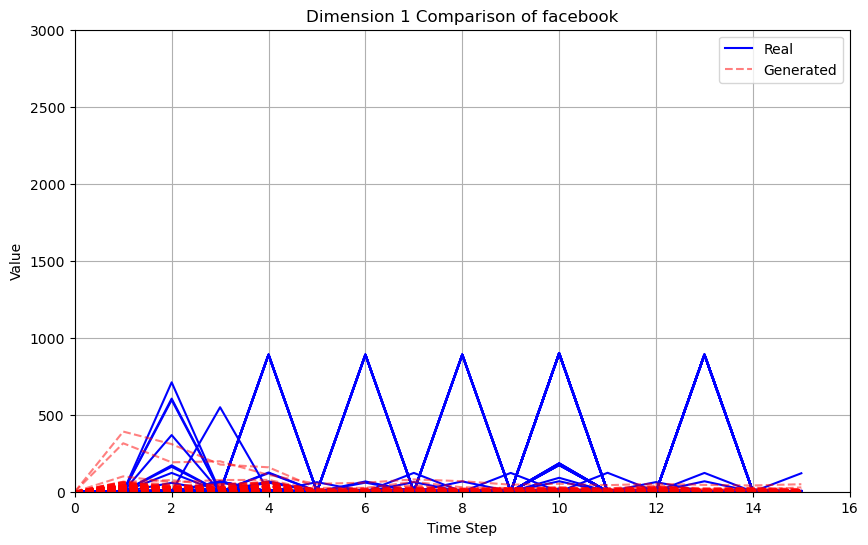

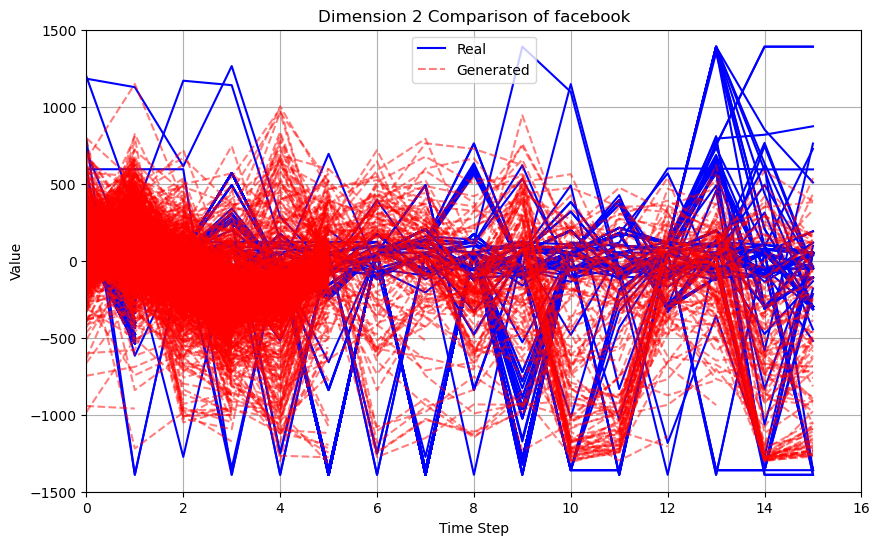

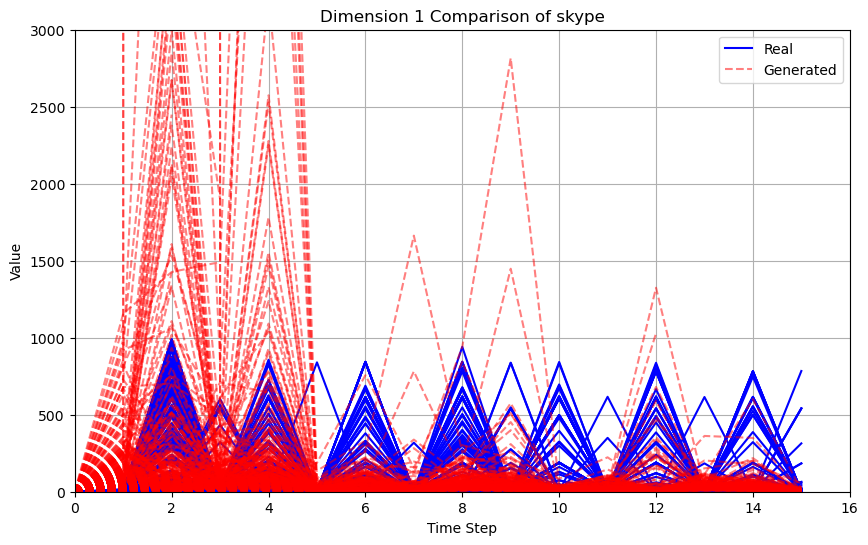

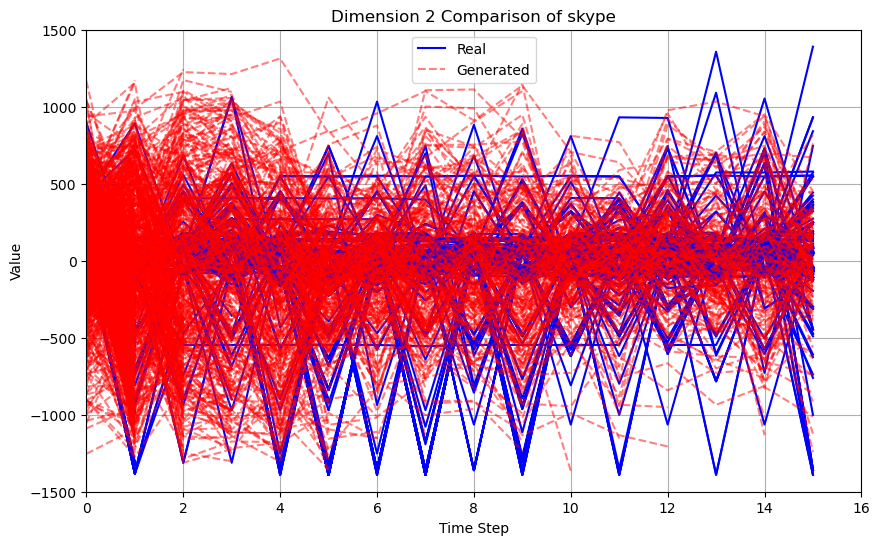

In [104]:
for label in LABEL_DICT.keys():
    real_data = real_datas[label]
    fake_data = fake_datas[label]
    real_sequences = np.array([pad(seq, MAX_SEQ_LEN) for seq in real_data])         # Shape: (num_samples, seq_len, num_dims)
    generated_sequences = np.array([pad(seq, MAX_SEQ_LEN) for seq in fake_data]) 

    num_samples, seq_len, num_dims = real_sequences.shape
    # print(real_sequences.shape)

    for dim in range(num_dims):
        
        percentiles = [10, 90]
        quantiles = np.nanpercentile(real_sequences[:,:,dim], percentiles, axis=0)
        
        plt.figure(figsize=(10, 6))
        
        if dim == 0:
            plt.axis([0, 16, 0, 3000])
        else:
            plt.axis([0, 16, -1500, 1500])

        # 绘制真实数据序列（统一颜色）
        for i in range(len(real_sequences)):
            plt.plot(real_sequences[i, :, dim], color='blue', alpha=1.0, label="Real" if i == 0 else "")  # 使用蓝色，透明度为 0.6
    
        # 绘制生成数据序列（统一颜色）
        for i in range(len(generated_sequences)):
            plt.plot(generated_sequences[i, :, dim], color='red', alpha=0.5, linestyle='--', label="Generated" if i == 0 else "")  # 使用红色，透明度为 0.6
            
        # for q in quantiles:
        #     plt.plot(q, color='green', linestyle='--', linewidth=2.5, label='Real Data Quantiles' if 'Real Data Quantiles' not in plt.gca().get_legend_handles_labels()[1] else "")
    
        plt.title(f"Dimension {dim + 1} Comparison of {label}")
        plt.xlabel("Time Step")
        plt.ylabel("Value")
        plt.legend()
        plt.grid(True)
        plt.show()
        

In [105]:
import ot  # optimal transport library

def hamming_distance_matrix(X, Y):
    X = np.array(X)
    Y = np.array(Y)
    batch_size = len(X)
    cost_matrix = np.zeros((batch_size, batch_size))
    for i in range(batch_size):
        for j in range(batch_size):
            cost_matrix[i, j] = np.sum(X[i] != Y[j])
    return cost_matrix


X = np.array([
    [[0, 1], [1, 0]],  # 样本 1
    [[2, 3], [3, 2]]   # 样本 2
])
Y1 = np.array([
    [[2, 3], [3, 2]],  # 样本 1
    [[0, 1], [1, 0]]   # 样本 2
])
Y2 = np.array([
    [[100, 101], [101, 100]],  # 样本 1
    [[-98, -97], [-97, -98]]   # 样本 2
])

# 计算 X 和 Y 之间所有样本对的距离矩阵
# cost_matrix_Y1 = np.linalg.norm(X[:, None, :, :] - Y1[None, :, :, :], axis=(-2, -1))
# cost_matrix_Y2 = np.linalg.norm(X[:, None, :, :] - Y2[None, :, :, :], axis=(-2, -1))
cost_matrix_Y1 = hamming_distance_matrix(X, Y1)
cost_matrix_Y2 = hamming_distance_matrix(X, Y2)

# 计算最优传输距离
ot_distance_Y1 = ot.emd2([], [], cost_matrix_Y1)  # Optimal Transport Distance
ot_distance_Y2 = ot.emd2([], [], cost_matrix_Y2)

print("OT 距离 (X vs Y1, 预期相同):", ot_distance_Y1)  # 应该接近 0
print("OT 距离 (X vs Y2, 预期不同):", ot_distance_Y2)  # 应该很大


OT 距离 (X vs Y1, 预期相同): 0.0
OT 距离 (X vs Y2, 预期不同): 4.0


In [106]:
# optimal transport distance
for label in LABEL_DICT.keys():
    real_data = real_datas[label]
    fake_data = fake_datas[label]
    real_sequences = np.array([pad(seq, MAX_SEQ_LEN) for seq in real_data])         # Shape: (num_samples, seq_len, num_dims)
    generated_sequences = np.array([pad(seq, MAX_SEQ_LEN) for seq in fake_data]) 

    num_samples, seq_len, num_dims = real_sequences.shape
    # print(real_sequences.shape)

    # for dim in range(num_dims):
    X = real_sequences
    Y = generated_sequences
        
        # Z = np.random.rand(Y.shape[0], Y.shape[1])  # 随机生成一个矩阵
        
    X_filled = np.nan_to_num(X, nan=10000)  # 或者 nan=0，如果认为0不影响
    Y_filled = np.nan_to_num(Y, nan=10000)
    
    # X_filled = X_filled / 1500
    # Y_filled = Y_filled / 1500
        
    # cost_matrix = np.linalg.norm(np.cumsum(X, axis=0)[:, None, :] - np.cumsum(Y, axis=0)[None, :, :], axis=-1)
    cost_matrix = np.linalg.norm(X_filled[:, None, :, :] - Y_filled[None, :, :, :], axis=(-2, -1))
        
    # print(cost_matrix.shape)
    ot_distance = ot.emd2([], [], cost_matrix) 
        
    print(f"OT 距离 {label} {dim}:", ot_distance)
    
        
        # percentiles = [10, 90]
        # quantiles = np.nanpercentile(real_sequences[:,:,dim], percentiles, axis=0)
        
        # plt.figure(figsize=(10, 6))
        
        # if dim == 0:
        #     plt.axis([0, 16, 0, 3000])
        # else:
        #     plt.axis([0, 16, -1500, 1500])

        # # 绘制真实数据序列（统一颜色）
        # for i in range(len(real_sequences)):
        #     plt.plot(real_sequences[i, :, dim], color='blue', alpha=1.0, label="Real" if i == 0 else "")  # 使用蓝色，透明度为 0.6
    
        # # 绘制生成数据序列（统一颜色）
        # for i in range(len(generated_sequences)):
        #     plt.plot(generated_sequences[i, :, dim], color='red', alpha=0.5, linestyle='--', label="Generated" if i == 0 else "")  # 使用红色，透明度为 0.6

OT 距离 facebook 1: 20463.34574627747
OT 距离 skype 1: 16292.082457080514
